# **ADA TS 23 PROJECT**
Student: Marko Šunjka
ID: 23/2022

Brief: This Colab notebook is meant to showcase the process behind implementing the QNPy on a dataset of time-dependent quasar observation. *italicized text*

In [46]:
#A series of code of me trying to get QNPy to load (took me 3 hours)
#import sys
#import os
#notebook_dir = os.getcwd()
#parent_dir = notebook_dir
#if parent_dir not in sys.path:
#    sys.path.append(parent_dir)
#import QNPy
#this worked
!pip install QNPy
!pip install numpy matplotlib scipy MFDFA astropy


In [148]:
#Importing packages used
import logging
import numpy as np
import pandas as pd
from MFDFA import MFDFA
from astropy.timeseries import LombScargle
import matplotlib.pyplot as plt
import glob as glob
import os
!pip show torch
!pip install torch torchvision torchaudio
import torch #this fails on its own
#verifying torch
print(torch.__version__)
print(torch.rand(2, 3))  # This should output a random tensor

#Importing QNPy dependancies
import QNPy
#For preprocess
from QNPy import Preprocess as pr #Importing Preprocess module from the package
from QNPy.Preprocess import transform #importing the funcion transform for transformation the data
from QNPy.Preprocess import * #importing all external packages from Preprocess
# For splitting and training
from QNPy import SPLITTING_AND_TRAINING as st
from QNPy.SPLITTING_AND_TRAINING import *
# For prediction 
from QNPy import PREDICTION as pred #Importing PREDICTION module from the package
from QNPy.PREDICTION import * #Importing all packages from PREDICTION module
from QNPy.PREDICTION import plot_function #The functions plot_function must be imported separately


Name: torch
Version: 2.1.2
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: C:\Users\uie42051\AppData\Local\anaconda3\Lib\site-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: torchaudio, torchvision
2.1.2+cpu
tensor([[0.9077, 0.3192, 0.8036],
        [0.5767, 0.6570, 0.4926]])


In [54]:
print(os.getcwd())

C:\Users\uie42051\Desktop\ADA23-MS-TS-main


In [53]:
os.chdir('C:/Users/uie42051/Desktop/ADA23-MS-TS-main')

In [67]:
input_dir = './kriveu'
csv_dir = './csv_files'
os.makedirs(csv_dir, exist_ok=True)

for file in os.listdir(input_dir):
    print("Found file:", file)  # Print the name of each found file
    file_path = os.path.join(input_dir, file)
    print("Processing file:", file_path)
    try:
        # Read the file without specifying header=None and names
        df = pd.read_csv(file_path)
        csv_path = os.path.join(csv_dir, file + '.csv')
        df.to_csv(csv_path, index=False)
        print("Saved CSV:", csv_path)
    except Exception as e:
        print("Error processing file:", file_path, "\nError:", e)

Found file: 1384186
Processing file: ./kriveu\1384186
Saved CSV: ./csv_files\1384186.csv
Found file: 1384482
Processing file: ./kriveu\1384482
Saved CSV: ./csv_files\1384482.csv
Found file: 1384888
Processing file: ./kriveu\1384888
Saved CSV: ./csv_files\1384888.csv
Found file: 1385148
Processing file: ./kriveu\1385148
Saved CSV: ./csv_files\1385148.csv
Found file: 1385498
Processing file: ./kriveu\1385498
Saved CSV: ./csv_files\1385498.csv
Found file: 1385693
Processing file: ./kriveu\1385693
Saved CSV: ./csv_files\1385693.csv
Found file: 1392335
Processing file: ./kriveu\1392335
Saved CSV: ./csv_files\1392335.csv
Found file: 1396377
Processing file: ./kriveu\1396377
Saved CSV: ./csv_files\1396377.csv
Found file: 1396861
Processing file: ./kriveu\1396861
Saved CSV: ./csv_files\1396861.csv
Found file: 1397099
Processing file: ./kriveu\1397099
Saved CSV: ./csv_files\1397099.csv
Found file: 1397703
Processing file: ./kriveu\1397703
Saved CSV: ./csv_files\1397703.csv
Found file: 1399759
P

In [74]:
padding = pr.backward_pad_curves(csv_dir, './Padded_lc', desired_observations=100)
for file in os.listdir('./Padded_lc'):
    rows, columns = df.shape
    print("This file has", rows, "rows.", "File name:", file)

Created new file: ./Padded_lc\1384186.csv
Created new file: ./Padded_lc\1384482.csv
Created new file: ./Padded_lc\1384888.csv
Created new file: ./Padded_lc\1385148.csv
Created new file: ./Padded_lc\1385498.csv
Created new file: ./Padded_lc\1385693.csv
Created new file: ./Padded_lc\1392335.csv
Created new file: ./Padded_lc\1396377.csv
Created new file: ./Padded_lc\1396861.csv
Created new file: ./Padded_lc\1397099.csv
Created new file: ./Padded_lc\1397703.csv
Created new file: ./Padded_lc\1399759.csv
Created new file: ./Padded_lc\1400894.csv
Created new file: ./Padded_lc\1405638.csv
Created new file: ./Padded_lc\1409195.csv
Created new file: ./Padded_lc\1461135.csv
This file has 113 rows. File name: 1384186.csv
This file has 113 rows. File name: 1384482.csv
This file has 113 rows. File name: 1384888.csv
This file has 113 rows. File name: 1385148.csv
This file has 113 rows. File name: 1385498.csv
This file has 113 rows. File name: 1385693.csv
This file has 113 rows. File name: 1392335.csv

In [131]:
DATA_SRC = "./Padded_lc" 
DATA_DST = "./preproc" 
os.makedirs(DATA_DST, exist_ok=True)
files = os.listdir(DATA_SRC)
number_of_points, trcoeff = pr.transform_and_save(files, DATA_SRC, DATA_DST, transform)

Data exploration with some new tricks

In [136]:
#New function for joining the various .csv's
def concatenate_csv_files(src_dir, dest_dir, new_filename):
    """
    param src_dir - Directory containing the CSV files to concatenate.
    param dest_dir - Directory where the new CSV file will be saved.
    param new_filename - Name for the new concatenated CSV file.
    """
    # Create the destination directory if it doesn't exist
    os.makedirs(dest_dir, exist_ok=True)

    # Find all CSV files in the source directory
    csv_files = glob.glob(os.path.join(src_dir, '*.csv'))

    # Initialize an empty list to store the DataFrames
    df_list = []

    # Loop over the list of csv files and read them into DataFrames
    for csv_file in csv_files:
        df = pd.read_csv(csv_file)
        df_list.append(df)

    # Concatenate all the DataFrames in the list into a single DataFrame
    concatenated_df = pd.concat(df_list, ignore_index=True)

    # Define the full path for the new concatenated CSV file
    concatenated_csv_path = os.path.join(dest_dir, new_filename)

    # Save the concatenated DataFrame to a new CSV file
    concatenated_df.to_csv(concatenated_csv_path, index=False)

    print(f'All CSV files in "{src_dir}" have been concatenated and saved to "{concatenated_csv_path}".')


In [139]:
#testing
concatenate_csv_files('./Padded_lc', './EA', "test.csv")

All CSV files in "./Padded_lc" have been concatenated and saved to "./EA\test.csv".


In [132]:
#using
concatenate_csv_files('./Padded_lc', './EA', "concatenated_data.csv")

All .csv files in ./Padded_lc have been concatenated and saved to ./EA\concatenated_data.csv


In [151]:
#Simple data exploration
data = pd.read_csv('./EA/test.csv')
print(data1.describe())

                mjd          mag       magerr
count   2004.000000  2004.000000  2004.000000
mean   53709.423857    21.350004     0.210637
std      664.331918     0.770850     0.158339
min    51464.200000    19.377098     0.036599
25%    53351.212500    20.747396     0.098852
50%    53995.450000    21.336027     0.162648
75%    54065.337500    21.895017     0.270744
max    54433.370000    23.890873     0.996839


In [152]:
#Simple data exploration
data = pd.read_csv('./EA/test.csv')
print(data1.describe())

                mjd          mag       magerr
count   2004.000000  2004.000000  2004.000000
mean   53709.423857    21.350004     0.210637
std      664.331918     0.770850     0.158339
min    51464.200000    19.377098     0.036599
25%    53351.212500    20.747396     0.098852
50%    53995.450000    21.336027     0.162648
75%    54065.337500    21.895017     0.270744
max    54433.370000    23.890873     0.996839


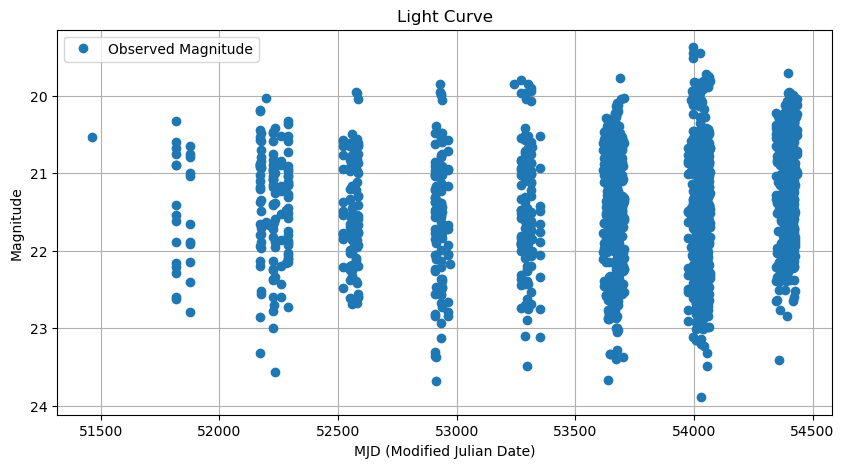

In [156]:
# Read the CSV file into a DataFrame
# Plot the light curve using 'mjd' for the x-axis and 'mag' for the y-axis
plt.figure(figsize=(10, 5))
plt.plot(data['mjd'], data['mag'], 'o', label='Observed Magnitude')
plt.title('Light Curve')
plt.xlabel('MJD (Modified Julian Date)')
plt.ylabel('Magnitude')
plt.gca().invert_yaxis()
plt.grid(True)
plt.legend()
plt.show()

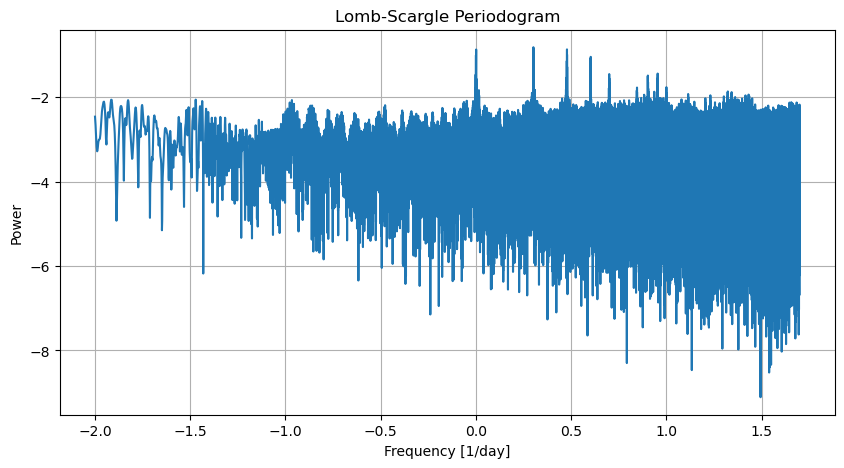

In [162]:
#PSD

t = data['mjd']
y = data['mag']

frequency_obs, power_obs = LombScargle(t, y).autopower(minimum_frequency=0.01, maximum_frequency=50)

plt.figure(figsize=(10, 5))
plt.plot(np.log10(frequency_obs), np.log10(power_obs))
plt.title('Lomb-Scargle Periodogram')
plt.xlabel('Frequency [1/day]')
plt.ylabel('Power')
plt.grid(True)
plt.show()

*Phase 2: Splitting & Training the data*

In [79]:
# Define the main dataset folder and subfolders
dataset_folder = './dataset'
train_folder = os.path.join(dataset_folder, 'train')
test_folder = os.path.join(dataset_folder, 'test')
val_folder = os.path.join(dataset_folder, 'val')

# Create the main dataset folder if it doesn't exist
if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

# Create train, test, and val subfolders
for folder in [train_folder, test_folder, val_folder]:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [80]:
DATA_SRC = "./preproc"
files = os.listdir(DATA_SRC)
#path to TRAIN, TEST and VAL folders where your splitted data will be saved. 
#You can directly enter this informations in split_data function
TRAIN_FOLDER = './dataset/train/'
TEST_FOLDER = './dataset/test/'
VAL_FOLDER = './dataset/val/'

In [81]:
#running the function for splitting the data
st.split_data(files, DATA_SRC, TRAIN_FOLDER, TEST_FOLDER, VAL_FOLDER) 

100%|█████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 237.00it/s]


In [146]:
concatenate_csv_files('./dataset/train', './EA', "train_data.csv")
concatenate_csv_files('./dataset/test', './EA', "test_data.csv")
concatenate_csv_files('./dataset/val', './EA', "val_data.csv")

All CSV files in "./dataset/train" have been concatenated and saved to "./EA\train_data.csv".
All CSV files in "./dataset/test" have been concatenated and saved to "./EA\test_data.csv".
All CSV files in "./dataset/val" have been concatenated and saved to "./EA\val_data.csv".


In [147]:
#Simple data exploration
test_x = pd.read_csv('./EA/test_data.csv')
train_x = pd.read_csv('./EA/train_data.csv')
val_x = pd.read_csv('./EA/val_data.csv')
print(test_x.describe())
print(train_x.describe())
print(val_x.describe())

             time        cont     conterr
count  980.000000  980.000000  980.000000
mean     0.926609   -0.116399    0.206416
std      0.996085    0.762012    0.151948
min     -2.000000   -2.000000    0.036599
25%      0.769054   -0.667019    0.101877
50%      1.338963   -0.136855    0.167474
75%      1.496462    0.367596    0.259662
max      2.000000    2.000000    0.972812
              time         cont      conterr
count  4265.000000  4265.000000  4265.000000
mean      0.900301    -0.203872     0.204177
std       1.018002     0.821281     0.156859
min      -2.000000    -2.000000     0.036599
25%       0.476242    -0.812291     0.095434
50%       1.337736    -0.223325     0.154860
75%       1.466478     0.370542     0.259826
max       2.000000     2.000000     0.996839
             time        cont     conterr
count  767.000000  767.000000  767.000000
mean     0.887505   -0.335212    0.251952
std      1.016161    0.788200    0.168040
min     -2.000000   -2.000000    0.056342
25%    

*Training the data*

In [85]:
DATA_PATH_TRAIN = "./dataset/train" #path to train folder
DATA_PATH_VAL = "./dataset/val" #path to val folder

MODEL_PATH = "./output/cnp_model.pth" #path for saving model

In [86]:
BATCH_SIZE=32 #Defining the batch size, it should remain 32
#running the function for getting the data loaders of data that are going to be trained
trainLoader, valLoader = st.get_data_loaders(DATA_PATH_TRAIN, DATA_PATH_VAL, BATCH_SIZE) 
#defining the device for testing, it can be CPU of CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
device

device(type='cpu')

In [87]:
#runing the function fo creating the model (deterministic model is default) 
#and optimiser (LogProbLoss), mseMetric (MSELoss)
model, optimizer, criterion, mseMetric, maeMetric = st.create_model_and_optimizer(device) 

In [88]:
#function for training the data
# numbers that we give in this example are: 
#1 - number of training runs
#3000 - number of epochs
#2000 - number of early stopping limit
# These numbers are optional and can be changed as needed.
history_loss_train, history_loss_val, \
history_mse_train, history_mse_val, \
history_mae_train, history_mae_val, \
epoch_counter_train_loss, epoch_counter_train_mse, \
epoch_counter_train_mae, epoch_counter_val_loss, \
epoch_counter_val_mse, epoch_counter_val_mae = st.train_model(
    model, trainLoader, valLoader, criterion, optimizer, 1, 3000, 2000, mseMetric, maeMetric, device)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [05:22<00:00,  9.30it/s]


In [89]:
# Define the file names for saving the lists for all histories
file_names = ["history_loss_train.csv", "history_loss_val.csv", "history_mse_train.csv", "history_mse_val.csv",
              "history_mae_train.csv", "history_mae_val.csv", "epoch_counter_train_loss.csv",
              "epoch_counter_train_mse.csv", "epoch_counter_train_mae.csv", "epoch_counter_val_loss.csv",
              "epoch_counter_val_mse.csv", "epoch_counter_val_mae.csv"]

# Define the lists
lists = [history_loss_train, history_loss_val, history_mse_train, history_mse_val, history_mae_train,
         history_mae_val, epoch_counter_train_loss, epoch_counter_train_mse, epoch_counter_train_mae,
         epoch_counter_val_loss, epoch_counter_val_mse, epoch_counter_val_mae]

In [90]:
#running the function for saving all lists with histories
save_list= st.save_lists_to_csv(file_names, lists)

In [92]:
# Replace with the path to your history_loss_train CSV file
history_loss_train_file = './history_loss_train.csv'  
# Replace with the path to your history_loss_val CSV file
history_loss_val_file = './history_loss_val.csv'  
# Replace with the path to your epoch_counter_train_loss CSV file
epoch_counter_train_loss_file = './epoch_counter_train_loss.csv'  

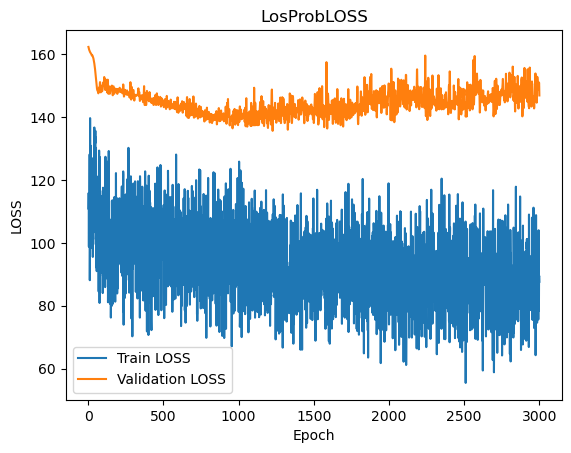

In [93]:
#plotting the Logprobloss after training
logprobloss=st.plot_loss(history_loss_train_file, history_loss_val_file, epoch_counter_train_loss_file)

In [94]:
 # Replace with the path to your history_mse_train CSV file
history_mse_train_file = './history_mse_train.csv'
# Replace with the path to your history_mse_val CSV file
history_mse_val_file = './history_mse_val.csv'  
# Replace with the path to your epoch_counter_train_mse CSV file
epoch_counter_train_mse_file = './epoch_counter_train_mse.csv'  

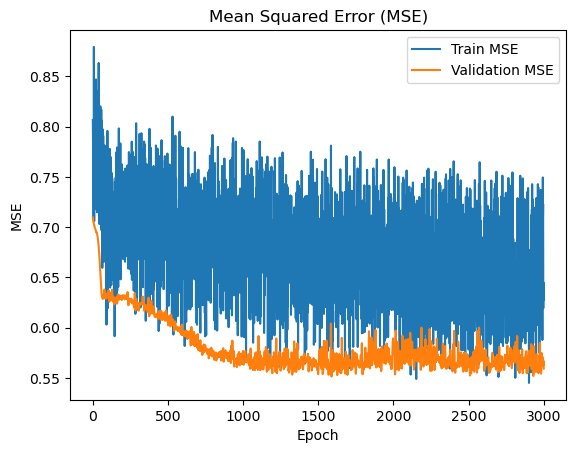

In [95]:
#plotting the MSE metric after training
msemetric=st.plot_mse(history_mse_train_file, history_mse_val_file, epoch_counter_train_mse_file)

In [96]:
# Replace with the path to your history_mae_train CSV file
history_mae_train_file = './history_mae_train.csv'
# Replace with the path to your history_mae_val CSV file
history_mae_val_file = './history_mae_val.csv'  
# Replace with the path to your epoch_counter_train_mae CSV file
epoch_counter_train_mae_file = './epoch_counter_train_mae.csv'  

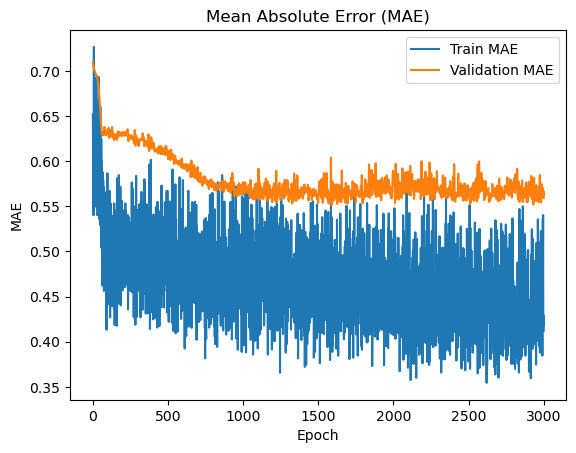

In [97]:
#plotting the MAE metric after training
maemetric=st.plot_mae(history_mae_train_file, history_mae_val_file, epoch_counter_train_mae_file)

In [98]:
save=st.save_model(model, MODEL_PATH)#saving the trained model

In [99]:
DATA_PATH_TRAIN = "./dataset/train" #path to train folder
DATA_PATH_VAL = "./dataset/val" #path to val folder
DATA_PATH_TEST="./dataset/test" #path to test folder
OUTPUT_PATH = "./output/predictions" #path where to save the plots and data

MODEL_PATH = "./output/cnp_model.pth" #path to saved model

In [101]:
pred.prepare_output_dir(OUTPUT_PATH)#clearing outputh dir, it can be sciped

In [103]:
model = pred.load_trained_model(MODEL_PATH, device) #loading the model

In [104]:
criterion, mseMetric= pred.get_criteria()#loading criterion and metrics from model

In [106]:
#deleting the padded values from test set
#deleting the curves that we add with plus and minus errors
#filtering the original curves for plotting

if __name__ == "__main__":
    folder_path = "./dataset/test"  # Change this to your dataset folder

    pred.remove_padded_values_and_filter(folder_path)

Deleted file with 'minus' or 'plus' in the name: 1384186_minus_split0.csv
Deleted file with 'minus' or 'plus' in the name: 1392335_minus_split18.csv
Removed padding in file: 1396377_original_split22.csv
Removed padding in file: 1397703_original_split31.csv
Deleted file with 'minus' or 'plus' in the name: 1399759_minus_split33.csv
Deleted file with 'minus' or 'plus' in the name: 1400894_plus_split38.csv
Deleted file with 'minus' or 'plus' in the name: 1409195_minus_split42.csv
Deleted file with 'minus' or 'plus' in the name: 1461135_minus_split45.csv


In [107]:
#deleting the padded values from train set
#deleting the curves that we add with plus and minus errors
#filtering the original curves for plotting

if __name__ == "__main__":
    folder_path = "./dataset/train"  # Change this to your dataset folder

    pred.remove_padded_values_and_filter(folder_path)
#deleting the padded values from val set
#deleting the curves that we add with plus and minus errors
#filtering the original curves for plotting

if __name__ == "__main__":
    folder_path = "./dataset/val"  # Change this to your dataset folder

    pred.remove_padded_values_and_filter(folder_path)
     

Removed padding in file: 1384186_original_split1.csv
Deleted file with 'minus' or 'plus' in the name: 1384186_plus_split2.csv
Deleted file with 'minus' or 'plus' in the name: 1384482_minus_split3.csv
Removed padding in file: 1384482_original_split4.csv
Deleted file with 'minus' or 'plus' in the name: 1384482_plus_split5.csv
Deleted file with 'minus' or 'plus' in the name: 1384888_minus_split6.csv
Removed padding in file: 1384888_original_split7.csv
Deleted file with 'minus' or 'plus' in the name: 1384888_plus_split8.csv
Deleted file with 'minus' or 'plus' in the name: 1385148_minus_split9.csv
Deleted file with 'minus' or 'plus' in the name: 1385148_plus_split11.csv
Deleted file with 'minus' or 'plus' in the name: 1385498_minus_split12.csv
Removed padding in file: 1385498_original_split13.csv
Deleted file with 'minus' or 'plus' in the name: 1385498_plus_split14.csv
Deleted file with 'minus' or 'plus' in the name: 1385693_minus_split15.csv
Deleted file with 'minus' or 'plus' in the name:

In [109]:
testLoader=pred.load_test_data(DATA_PATH_TEST)#loading test data
trainLoader=pred.load_train_data(DATA_PATH_TRAIN)#loading trained data
valLoader=pred.load_val_data(DATA_PATH_VAL)#loading validation data

In [111]:
#prediction and plotting the test data
testMetrics=pred.plot_light_curves_from_test_set(model, testLoader, criterion, mseMetric, plot_function, device)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


<Figure size 640x480 with 0 Axes>

In [121]:
saveTestMetric=pred.save_test_metrics('./output/predictions/', testMetrics)#saving the test Metrics

In [128]:
trainMetrics = pred.plot_light_curves_from_train_set(trainLoader, model, criterion, mseMetric, plot_function, device)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.73it/s]


<Figure size 640x480 with 0 Axes>

In [129]:
saveTrainMetric = pred.save_train_metrics('./output/predictions/', trainMetrics)#saving the train metrics 

In [125]:
#prediction and plotting the val data
valMetric=pred.plot_light_curves_from_val_set(model, valLoader, criterion, mseMetric, plot_function, device)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


<Figure size 640x480 with 0 Axes>

In [126]:
saveValMetrics=pred.save_val_metrics('./output/predictions/', valMetric)#saving the val metrics 